In [8]:
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = eval_gini(labels, preds)
    return [('gini', gini_score)]
def gini_xgb_neg(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

import time
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")

In [10]:
base_path = 'D:/DataSet/Credit/'
train = pd.read_csv(base_path + 'featured/train_all_feature.csv')
test = pd.read_csv(base_path + 'featured/test_all_feature.csv')

one_hot = 0
if one_hot:
    train = pd.get_dummies(train)
    test = pd.get_dummies(test)
    
col_to_drop = [
    # 1
    'count_house_loan_ln',# 0.97232912500359225)
    'count_house_loan',# 0.65395611105534779)
    'edu_level_other',# 0.57350198625873861)
    'count_payment_state_E_ln',# 0.51044888053676218)
    'count_attention_ln',# 0.32350891467937332)
    'count_commercial_loan',# 0.0)
    'count_sixty_ovd_dw',# 0.0)
    'count_sixty_ovd_months',# 0.0)
    'ind_sixty_max_duration',# 0.0)
    'marry_status_other',# 0.0)
    'count_study_loan_ln',# 0.0)
    'count_housing_accumulation_ln',# 0.0)
    'count_commercial_housing_ln',# 0.0)
    'count_combination_ensure_ln',# 0.0)
    'ind_other_counts_lnd',# 0.0)
    'count_combination_lnd',# 0.0)
    'count_pledge_guarantee_lnd',# 0.0)
    'count_ensure_lnd',# 0.0)
    'count_other_guarantee_lnd',# 0.0)
    'count_combination_ensure_lnd',# 0.0)
    'count_farmer_joint_lnd',# 0.0)
    'count_pledge_guarantee_lnd.1',# 0.0)
    # 10
    'ind_curr_overdue_cyc_lnd',# 9.1747017468829988)
    'ind_unact_counts_lnd',# 8.1829607049772104)
    'ind_other_counts',# 8.1190294047611253)
    'count_pledge_guarantee_ln.1',# 4.9866824922417035)
    'count_sharedebt',# 4.25470982342895)
    'marry_status_unmarried',# 3.5268450817329375)
    'count_normal_ln',# 3.1544560288384238)
    'count_farmer_joint_ln',# 2.8250789765495536)
    'not_clear_account_count',# 2.438362051462843)
    'count_car_loan_ln',# 2.0244134983035815)
    'count_payment_state_E_lnd',# 1.9511014375106948)
    # 40
    'ind_normal_counts',# 38.981578298058366)
    'count_ensure_ln',# 32.686012781155711)
    'not_logout_pre_account_count',# 29.035934862113912)
    'count_spl',# 26.621401271906876)
    'not_logout_pre_finance_org_count',# 20.88833411697636)
    'count_debit_card_ovd_dw',# 20.552771641255653)
    'ind_clear_counts_lnd',# 18.63633007759838)
    'cat_query_reason_mal',# 18.012892273855371)
    'count_other_guarantee_ln',# 15.719418555370231)
    'count_pledge_guarantee_ln',# 14.603172531948651)
    'count_standard_loancard',# 14.257967916620288)
    'count_combination_ln',# 13.225866749150008)
    'marry_status_divorced',# 12.996673186745294)
    'flt_highest_sixty_oa_per_mon',# 12.496437876453976)
    'count_farmer_loan_ln',# 12.034259912867824)
    # 60
    'curr_overdue_cyc_days',# 58.533138767951407)
    'not_logout_pre_max_credit_limit_per_org',# 55.545770066417433)
    'not_logout_pre_finance_corp_count',# 54.909995520093744)
    'has_fund',# 53.524477466077244)
    'edu_level_bachelor',# 51.681921368379456)
    'cat_query_reason_sqe',# 50.507370364531575)
    'not_clear_finance_org_count',# 50.499752342403504)
    'count_payment_state_B_ln',# 49.675949679726415)
    'count_ovd',# 47.284280675138668)
    'marry_status_married',# 47.141063732728689)
    # 100
    'count_payment_state_D_ln',# 98.582591891500016)
    'not_logout_finance_org_count',# 97.63379220401383)
    'count_credit_loan_ln',# 96.057688729626022)
    'count_payment_state_D_lnd',# 94.52677681813546)
    'all_highest_oa_per_mon',# 93.758390716396264)
    'count_consumption loan_ln',# 92.34403542313882)
    'not_logout_pre_latest_6m_used_avg_amount',# 85.357040829001591)
    'balance',# 85.186190705260103)
    'cat_query_reason_la',# 83.737758346562558)
    'ind_clear_counts',# 82.467554392775014)
    'count_unknown_ln',# 73.400641666623201)
    'not_logout_pre_min_credit_limit_per_org',# 70.752886069309909)
    'not_logout_pre_credit_limit',# 68.394379619115668)
    'not_logout_account_count',# 67.926934887483739)
    'lnd_ovd_sum_amount',# 67.598474433716945)
    'flt_highest_debit_card_oa_per_mon',# 64.9057845815354)
    'count_loan_ovd_dw',# 64.132474960621153)
    'count_operating_loan_ln',# 63.127772355688421)
    'not_clear_finance_corp_count',# 62.877948676798582)
    # 180
    'not_logout_latest_6m_used_avg_amount',# 176.32317263727683)
    'ind_loan_max_duration',# 167.56724876084013)
    'count_credit_loan_lnd',# 166.96045957856194)
    'all_max_duration',# 153.57957111737943)
    'not_clear_balance',# 153.18548993022915)
    'flt_highest_loan_oa_per_mon',# 150.5264464131252)
    'flt_sum_amount',# 149.83162201460962)
    'used_highest_amount_lnd',# 136.85598322859255)
    'scheduled_payment_amount',# 128.02030046387119)
    'latest6_month_used_avg_amount_lnd',# 124.58135686300396)
    'ind_org_counts',# 120.5490321578975)
    'ind_debit_card_max_duration',# 118.53218655429413)
    'edu_level_junior',# 117.02178169627837)
    'lnd_ovd_sum_last_months',# 114.74345491704378)
    'used_credit_limit_amount_lnd',# 114.2672848868574)
    'ave_ovd_amount',# 114.06571798355444)
    'count_other_loan',# 111.82596886962884)
    'range_lnd_ovd',# 109.13363916690426)
    'not_logout_pre_used_credit_limit',# 105.64340446411771)
    'count_sum_ovd_dw',# 104.97563024241767)
    # flt_noise
    'not_logout_max_credit_limit_per_org',# 211.80030432198566)
    # 240
    #'not_logout_finance_corp_count',# 217.97120979038462)
]

train = train.drop(col_to_drop, axis=1)
test = test.drop(col_to_drop,axis=1)

In [49]:
features = train.columns.drop(['y','report_id'])    # 列名
X = train.drop(['y','report_id'],axis=1)            # 不包含 target 的数据集
y = train.y                                         # 目标数据
sub=test.report_id.to_frame()                      # 用于储存结果
sub['pred']=0                                         # 初始化为 0
sub_train=train.report_id.to_frame()
sub_train['y']=train.y                                 # oof
sub_train['pred'] = 0


clf = xgb.XGBClassifier(n_estimators=300,max_depth=2,objective="binary:logistic",learning_rate=0.07, 
                        subsample=.8, colsample_bytree=.8,gamma=10,reg_alpha=8,reg_lambda=1.3,
                        min_child_weight=6,scale_pos_weight=1.6,#nthread=2,
                        )
clf.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=10, learning_rate=0.07, max_delta_step=0, max_depth=2,
       min_child_weight=6, missing=None, n_estimators=300, nthread=-1,
       objective='binary:logistic', reg_alpha=8, reg_lambda=1.3,
       scale_pos_weight=1.6, seed=0, silent=True, subsample=0.8)

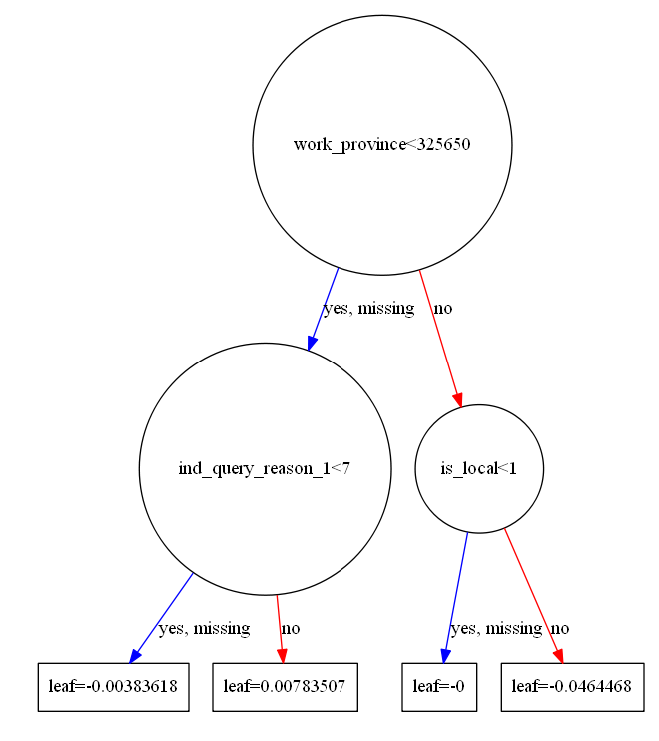

In [54]:
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plot_tree(clf,ax = ax,fmap='xgb.fmap',num_trees=180)
plt.show()